# Environment Setup

In [1]:
!pip install torch torchvision matplotlib numpy -q

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, Dataset
import numpy as np
import matplotlib.pyplot as plt
import random
import cv2
import os

# *Load model without retraining(upload it to env)

In [2]:
# from google.colab import files
# import torch

# # Upload the saved model
# uploaded = files.upload()

# # Initialize the model
# model = NumerosityCNN()  # Use your existing model class

# # Load the state dict
# model.load_state_dict(torch.load('numerosity_model.pth'))
# model.eval()

# print("Model reloaded and ready for inference!")

# GPU Configs

In [4]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU"}')

Using device: NVIDIA L4


# Synthetic Dot Patter Generation

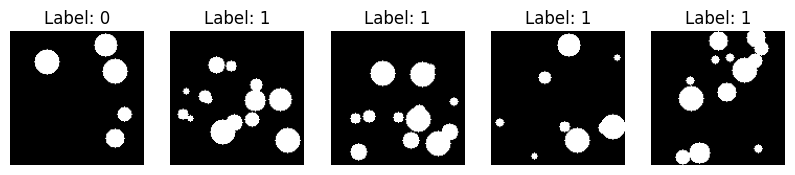

In [5]:
class DotPatternDataset(Dataset):
    def __init__(self, num_samples=5000, image_size=128, categories=(5, 15)):
        self.num_samples = num_samples
        self.image_size = image_size
        self.categories = categories
        self.data, self.labels = self.generate_dataset()

    def generate_dataset(self):
        data = []
        labels = []
        for _ in range(self.num_samples):
            img, label = self.generate_image()
            data.append(img)
            labels.append(label)
        return torch.stack(data), torch.tensor(labels, dtype=torch.long)

    def generate_image(self):
        img = np.zeros((self.image_size, self.image_size), dtype=np.float32)
        num_dots = random.randint(1, 30)
        for _ in range(num_dots):
            x = random.randint(5, self.image_size - 5)
            y = random.randint(5, self.image_size - 5)
            size = random.randint(3, 12)
            img = cv2.circle(img, (x, y), size, (255,), -1)
        img = torch.tensor(img).unsqueeze(0) / 255.0  # Normalize to [0,1]
        label = self.categorize(num_dots)
        return img, label

    def categorize(self, num_dots):
        if num_dots <= self.categories[0]:
            return 0  # Few
        elif num_dots <= self.categories[1]:
            return 1  # Medium
        else:
            return 2  # Many

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

# Visualize Sample Images
dataset = DotPatternDataset()
plt.figure(figsize=(10, 5))
for i in range(5):
    img, label = dataset[i]
    plt.subplot(1, 5, i+1)
    plt.imshow(img.squeeze(), cmap='gray')
    plt.title(f'Label: {label}')
    plt.axis('off')
plt.show()

# Data Saving

In [6]:
# Save PyTorch tensors
os.makedirs("saved_data", exist_ok=True)
torch.save(dataset.data, "saved_data/dataset_data.pt")
torch.save(dataset.labels, "saved_data/dataset_labels.pt")

# Save as NumPy arrays for portability
np.save("saved_data/dataset_data.npy", dataset.data.numpy())
np.save("saved_data/dataset_labels.npy", dataset.labels.numpy())

# Save dataset parameters
import json
dataset_params = {
    "num_samples": dataset.num_samples,
    "image_size": dataset.image_size,
    "categories": list(dataset.categories),  # Few, Medium, Many thresholds
    "dot_size_range": [3, 12],
    "variations": ["random size", "random position", "random density"]
}
with open("saved_data/dataset_params.json", "w") as f:
    json.dump(dataset_params, f, indent=4)

print("Dataset and parameters saved successfully!")

Dataset and parameters saved successfully!


# Data Loaders for Training & Testing

In [7]:
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Define CNN Model

In [8]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        return self.relu(out)

class NumerosityCNN(nn.Module):
    def __init__(self):
        super(NumerosityCNN, self).__init__()
        self.layer1 = nn.Sequential(
            ResidualBlock(1, 32),
            nn.MaxPool2d(2)
        )
        self.layer2 = nn.Sequential(
            ResidualBlock(32, 64),
            nn.MaxPool2d(2)
        )
        self.layer3 = nn.Sequential(
            ResidualBlock(64, 128),
            nn.MaxPool2d(2)
        )
        self.fc1 = nn.Linear(128 * 16 * 16, 128)
        self.fc2 = nn.Linear(128, 3)  # Few, Medium, Many

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(out.size(0), -1)
        out = torch.relu(self.fc1(out))
        return self.fc2(out)

model = NumerosityCNN()

In [9]:
model.to(device)

NumerosityCNN(
  (layer1): Sequential(
    (0): ResidualBlock(
      (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential(
        (0): Conv2d(1, 32, kernel_size=(1, 1), stride=(1, 1))
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): ResidualBlock(
      (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): 

# Training the Model

In [10]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

def train_model_with_early_stopping(num_epochs=10, patience=3):
    model.train()
    best_loss = float('inf')
    patience_counter = 0

    for epoch in range(num_epochs):
        total_loss = 0
        for i, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

        # Early stopping logic
        if avg_loss < best_loss:
            best_loss = avg_loss
            patience_counter = 0
            torch.save(model.state_dict(), 'best_model.pth')
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

train_model_with_early_stopping()

Epoch [1/10], Loss: 1.2657
Epoch [2/10], Loss: 0.2182
Epoch [3/10], Loss: 0.1561
Epoch [4/10], Loss: 0.1626
Epoch [5/10], Loss: 0.1490
Epoch [6/10], Loss: 0.0872
Epoch [7/10], Loss: 0.0771
Epoch [8/10], Loss: 0.0790
Epoch [9/10], Loss: 0.0524
Epoch [10/10], Loss: 0.0375


# Save model after training

In [11]:
torch.save(model.state_dict(), 'numerosity_model.pth')
print("Model saved successfully!")

Model saved successfully!


# Model Evaluation

In [12]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy on test data: {100 * correct / total:.2f}%')

Accuracy on test data: 90.80%
